In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
from tensorflow.random import normal, uniform
import matplotlib.image as mpimg
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
import glob
import warnings


2021-09-07 11:43:48.904357: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
warnings.filterwarnings('ignore')

In [260]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.__dens1 = tf.keras.layers.Dense(1024)  
        self.__normal1 = tf.keras.layers.BatchNormalization()
        self.__leak1 = tf.keras.layers.LeakyReLU()
        
        self.__reshape = tf.keras.layers.Reshape((32, 32, 1))    
        self.__conv1 = tf.keras.layers.Conv2DTranspose(250, (5, 5), padding='SAME')
        self.__normal2 = tf.keras.layers.BatchNormalization()
        self.__leak2 = tf.keras.layers.LeakyReLU()
        
        self.__conv2 = tf.keras.layers.Conv2DTranspose(125, (5, 5), padding='SAME')
        self.__normal3 = tf.keras.layers.BatchNormalization()
        self.__leak3 = tf.keras.layers.LeakyReLU()
        
        self.__conv3 = tf.keras.layers.Conv2DTranspose(1, (5, 5), padding='SAME')
        
    def call(self, x):
        output = self.__dens1(x)
        output = self.__normal1(output)
        output = self.__leak1(output)
        
        output = self.__reshape(output)
        output = self.__conv1(output)
        output = self.__normal2(output)
        output = self.__leak2(output)
        
        output = self.__conv2(output)
        output = self.__normal3(output)
        output = self.__leak3(output)
        
        output = self.__conv3(output)
        
        return output


class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.__conv2d_1 = tf.keras.layers.Conv2D(100, (50, 50), (1, 1), padding='SAME')
        self.__pool_1 = tf.keras.layers.MaxPool2D(pool_size=(20, 20), padding='SAME')
        self.__conv2d_2 = tf.keras.layers.Conv2D(50, (50, 50), (1, 1), padding='SAME')
        self.__pool_2 = tf.keras.layers.MaxPool2D(pool_size=(20, 20), padding='SAME')        
        self.__flatten = tf.keras.layers.Flatten()
        self.__perceptron = tf.keras.layers.Dense(2)
        self.__softmax = tf.keras.layers.Softmax()
        
    def call(self, x):
        return self.__softmax(self.__perceptron((self.__flatten(self.__pool_2(self.__conv2d_2(self.__pool_1(self.__conv2d_1(x))))))))
            
class Gan():
    def __init__(self):
        self.__discriminator = Discriminator()
        self.__generator = Generator()
        self.__gan = Sequential()
        self.__gan.add(self.__generator)
        self.__gan.add(self.__discriminator)
        
        self.__loss_object_discr = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.__optimizer_discr = tf.keras.optimizers.Adam()
        self.__optimizer_gen = tf.keras.optimizers.Adam()
        self.__loss_object_gen = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  
        
        self.__discriminator.compile(self.__optimizer_discr, self.__loss_object_discr)
        self.__gan.compile(self.__optimizer_gen, self.__loss_object_gen)        
    
    def generate_image(self, noise_gen):
        return self.__generator(noise_gen)
    
    def train_on_batch(self, x_true, y_true, x_fake_img_gen, y_fake_img_gen):
        cost_discriminator = self.__discriminator.train_on_batch(X_true, Y_true)
        cost_gan = self.__gan.train_on_batch(x_fake_img_gen, y_fake_img_gen)
        print("Cost Discriminator : {}\nCost Gan : {}".format(cost_discriminator, cost_gan))        
        

In [92]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [261]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

dataset = { class_names[i]:[] for i in range(0, len(class_names)) }

for image, label in zip(train_images, train_labels):
    dataset[class_names[label[0]]].append(0.2989*image[:, :, 0] + 0.5870 *image[:, :, 1] + 0.1140*image[:, :, 2])
    
current_dataset = np.array(dataset['airplane'])[0:1000, :, :]
IMG_BATCH, IMG_H, IMG_W = current_dataset.shape
current_dataset = current_dataset.reshape(IMG_BATCH, IMG_H, IMG_W, 1)
IMG_BATCH, IMG_H, IMG_W, IMG_C = current_dataset.shape
print(current_dataset.shape)
NOISE_BATCH, NOISE_H = (50, 500)

(1000, 32, 32, 1)


In [262]:
gan_model = Gan()

for epoch in range(0, 10):
    x_true_image = []
    for img in current_dataset:
        x_true_image_current = img/255
        x_true_image.append(x_true_image_current)
        
    #True image
    x_true_image = np.concatenate(x_true_image, 0)
    x_true_image = tf.constant(np.array(x_true_image).reshape((IMG_BATCH, IMG_H, IMG_W, IMG_C)), dtype=tf.dtypes.float32)
    
    #Noises input 
    noise_discr = tf.random.uniform((NOISE_BATCH, NOISE_H), 0, 1)
    noise_gen = tf.random.uniform((NOISE_BATCH, NOISE_H), 0, 1)
    
    X_fake_img = gan_model.generate_image(noise_discr)
    
    X_true = tf.concat([x_true_image, X_fake_img], 0)
    
    y_disc = np.ones(IMG_BATCH+NOISE_BATCH)
    y_disc[:IMG_BATCH] = 0
    y_disc = tf.constant(y_disc, dtype=tf.dtypes.float32)
    
    Y_true = tf.concat([y_disc], 0)
    
    Y_fake_img_gen = np.ones(NOISE_BATCH)
    Y_fake_img_gen = tf.constant(Y_fake_img_gen, dtype=tf.dtypes.float32)    

    #Training
    gan_model.train_on_batch(X_true, Y_true, noise_gen, Y_fake_img_gen)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cost Discriminator : 0.6921643018722534
Cost Gan : 0.8961939811706543
Cost Discriminator : 0.4235858619213104
Cost Gan : 1.3091866970062256
Cost Discriminator : 0.3492467403411865
Cost Gan : 1.2691123485565186
Cost Discriminator : 0.3582194149494171
Cost Gan : 0.7761508822441101
Cost Discriminator : 0.3454502522945404
Cost Gan : 0.3156983256340027
Cost Discriminator : 0.3241778016090393
Cost Gan : 0.3132629692554474
Cost Discriminator : 0.315679728

(-0.5, 31.5, 31.5, -0.5)

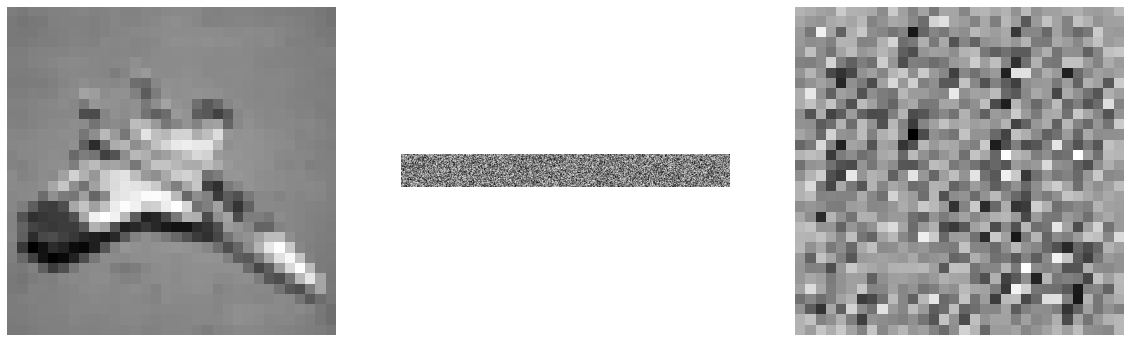

In [270]:
noise_test = tf.random.uniform((NOISE_BATCH, NOISE_H), 0, 1)
fake_image_to_print = gan_model.generate_image(noise_test)[1]
fake_image_to_print = (fake_image_to_print - tf.reduce_min(fake_image_to_print)) / (tf.reduce_max(fake_image_to_print) - tf.reduce_min(fake_image_to_print))

image_from_train = current_dataset[1]

figure = plt.subplots(figsize=(20,10))
ax = plt.subplot(131)
ax.imshow(image_from_train, cmap='gray')
ax.axis('off')
ax = plt.subplot(132)
ax.imshow(noise_test, cmap='gray')
ax.axis('off')
ax = plt.subplot(133)
ax.imshow(fake_image_to_print, cmap='gray')
ax.axis('off')